# 03. Pipeline: Processamento de artigos científicos

Executar o comando:
```
pip install nltk
```

1. Carregamento dos dados
2. Pré-processamento
4. Vetorização (Bag-of-Words + TFIDF)
3. Clustering
4. Redução de dimensionalidade
5. Projeção dos dados

## O conjunto de dados

O conjunto de dados consiste de 675 artigos científicos. As instâncias incluem: título, autoria, affiliação, resumo e referências.

O conjunto de dados cobre 4 subáreas da ciência da computação:

| Campo do conhecimento | Classe | Nº de Documentos |
| :--- | :---: | :---: |
| Case-Based Reasoning | CBR | 276 |
| Inductive Logic Programming | ILP | 119 |
| Information Retrieval | RI | 179 |
| Sonification | SON | 101 |
| | **TOTAL** | 675 |

> [1] Paulovich, F. V. (2008). Mapeamento de dados multi-dimensionais - integrando mineração e visualização. Tesis Doctoral, Instituto de Ciências Matemáticas e de Computação, Universidad de São Paulo, São Carlos. doi:10.11606/T.55.2008.tde-04032009-145018.

Download NLTK data

In [1]:
import nltk
nltk.download(["stopwords", "wordnet", "punkt", "averaged_perceptron_tagger"])

[nltk_data] Downloading package stopwords to /home/eric/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/eric/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/eric/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/eric/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

Carrega os dados

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np

data = pd.read_csv("./data/cbr_ilp_ir_son.csv", sep=",")

target_names = data["Label"].unique()

data_X = data["Content"]

data_Y = np.array([
    np.where(target_names == i)[0][0] for i in data["Label"]])

display(data_X)

0      A Hybrid Knowledge-Based System for Technical ...
1      A Case-Based Reasoner Adaptive to Different Co...
2      Case-Based Reasoning for Information System De...
3      Loose Coupling of Failure Explanation and Repa...
4      Virtual Function Generators: Representing and ...
                             ...                        
670    A-Subsumption and Its Application to Learning ...
671    Generating Numerical Literals During Refinemen...
672    Distance Between Herbrand Interpretations: A M...
673    Approximate ILP Rules by Backpropagation Neura...
674    Rule Evaluation Measures: A Unifying View  Nad...
Name: Content, Length: 675, dtype: object

## Pré-processamento de texto

1. Transforma para minúsculo
2. Remove símbolos
3. Remove pontuações
4. Remove números
5. Remove espaços em branco
6. Lematização (WordNet Lemmatizer)
7. Tokenização
8. Remove palavras vazias (stopwords)

In [3]:
from nltk.corpus import stopwords, wordnet
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer

import numpy as np
import re, string

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {
        "J": wordnet.ADJ,
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def clean_text(text: str) -> str:
    punctuation = r"[{0}]".format(re.sub(r"[-']", "", string.punctuation))
    return " ".join(list(filter(lambda x: x != "", [          # 5th extra whitespaces
        re.sub(r"^\d+$", r"", i) for i in re.findall(r"\S+",  # 4th numerics
            re.sub(punctuation, " ",                          # 3th Punctuation 
                re.sub(r'[^\x00-\xb7f\xc0-\xff]', r' ',       # 2nd symbols 
                    text.lower())))]))).strip()               # 1st lowercase
                

def process_text(text: str) -> np.array:
    ## Clean text
    # To lowercase
    # Remove non-ascii characters
    # Remove punctuation
    # Remove numbers
    text = clean_text(text)
    
    ## Get stopwords from
    # NLTK
    stop_words = stopwords.words("english")

    # WORDNET LEMMATIZER (NLTK)
    lemmatizer = WordNetLemmatizer()
    return np.array([
        lemmatizer.lemmatize(               ## LEMMATIZE
            token, get_wordnet_pos(token)
        ) for token in word_tokenize(text)  # TOKENIZE
        if token not in stop_words])         # REMOVE STOPWORDS

## Vetorização de documentos

* Modelo *Bag-of-Words*
* Balanceamento por TFIDF
> $TFIDF_{t, d} = TF_{t, d} \times \log{\frac{|D|}{DF_t}}$
    * $TF_{t, d}$: Frequência do termo $t$ no documento $d \in D$
    * $|D|$: Tamanho do corpus
    * $DF_t$: Numero de documentos com o termo $t$
* Regra de Zipf's e corte de Luhn's

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

n_gram = (1, 2)
upper_cut = 0.6
lower_cut = 0.1

data_vectorizer = TfidfVectorizer(
    ngram_range=n_gram,
    max_df=upper_cut,
    min_df=lower_cut,
    encoding="utf-8",
    lowercase=True,
    tokenizer=process_text,
    decode_error="ignore")

data_preprocessed = data_vectorizer.fit_transform(data_X)

print("Tamanho do vocabulário: {}".format(data_preprocessed.shape[1]))

Tamanho do vocabulário: 429


## Clustering de documentos

* KMeans
> $\sum^{|X|}_{i=0} \min_{\mu_j \in C}(||x_i - \mu_j||^2)$
    * X: Conjunto de dados
    * C: Centroides dos clusters
    * $\mu_j$: Centroide do j-ézimo cluster, obtido pela média das instâncias membros
* Norma $l^2$ vs. Z-score

In [5]:
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    adjusted_mutual_info_score,
    adjusted_rand_score,
    v_measure_score,
    fowlkes_mallows_score)

metrics = [
    silhouette_score,
    adjusted_mutual_info_score,
    adjusted_rand_score,
    v_measure_score,
    fowlkes_mallows_score]

data_clusters = KMeans(
    n_clusters=4
).fit_predict(data_preprocessed)

data_clusters_std = make_pipeline(
    StandardScaler(with_mean=False),
    KMeans(n_clusters=4)
).fit(data_preprocessed).predict(data_preprocessed)

data_clusters_norm = make_pipeline(
    Normalizer(norm="l2"),
    KMeans(n_clusters=4)
).fit(data_preprocessed).predict(data_preprocessed)

data_metrics = pd.DataFrame({
    "Métrica": [
        "Silhouette",
        "Adjusted Mutual Information",
        "Adjusted Rand Index",
        "V-Measure",
        "Fowlkes-Mallows"],
    "Padrão": [metrics[0](data_preprocessed, data_clusters)] + [
                metric(data_Y, data_clusters)
                for metric in metrics[1:]],
    "Z-score": [metrics[0](data_preprocessed, data_clusters_std)] + [
                metric(data_Y, data_clusters_std)
                for metric in metrics[1:]],
    "Norma l²": [metrics[0](data_preprocessed, data_clusters_norm)] + [
                metric(data_Y, data_clusters_norm)
                for metric in metrics[1:]]})

display(data_metrics)

,Métrica,Padrão,Z-score,Norma l²
0,Silhouette,0.120297,0.088842,0.120037
1,Adjusted Mutual Information,0.828659,0.695868,0.825372
2,Adjusted Rand Index,0.859683,0.665206,0.843757
3,V-Measure,0.829532,0.697479,0.826261
4,Fowlkes-Mallows,0.899723,0.767197,0.888319


# Redução de dimensionalidade

t-SNE
* Norma $l^2$ vs. Z-score

Classes verdadeiras


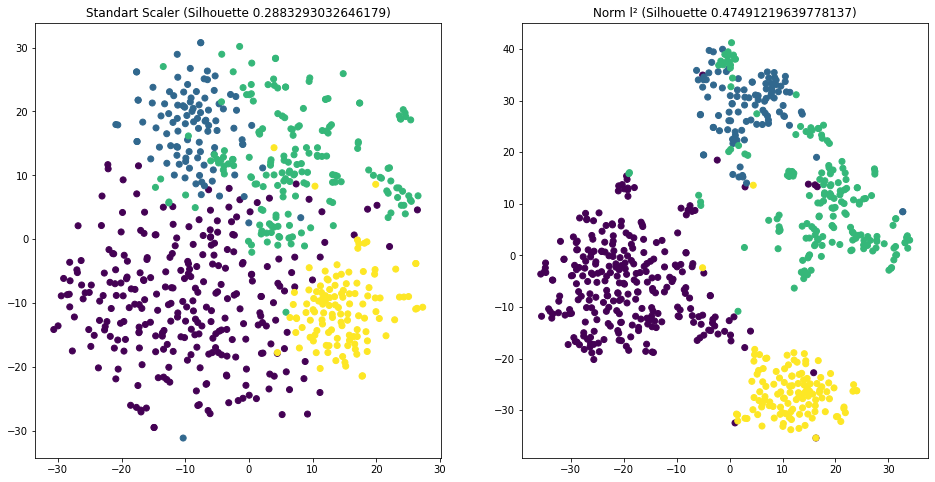

In [6]:
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

data_tsne_std = make_pipeline(
    StandardScaler(with_mean=False),
    TSNE(n_components=2,perplexity=30)
).fit_transform(data_preprocessed)

data_tsne_norm = make_pipeline(
    Normalizer(norm="l2"),
    TSNE(n_components=2,perplexity=30)
).fit_transform(data_preprocessed)

data_fig, data_axs = plt.subplots(1, 2)
data_fig.set_figwidth(16)
data_fig.set_figheight(8)

print("Classes verdadeiras")
data_axs[0].scatter(
    x=data_tsne_std[:,0], y=data_tsne_std[:,1],
    c=data_Y)
data_axs[0].set_title("Standart Scaler (Silhouette {})".format(
    silhouette_score(data_tsne_std, data_Y, metric="euclidean")))

data_axs[1].scatter(
    x=data_tsne_norm[:,0], y=data_tsne_norm[:,1],
    c=data_Y)
data_axs[1].set_title("Norm l² (Silhouette {})".format(
    silhouette_score(data_tsne_norm, data_Y, metric="euclidean")))

plt.show()

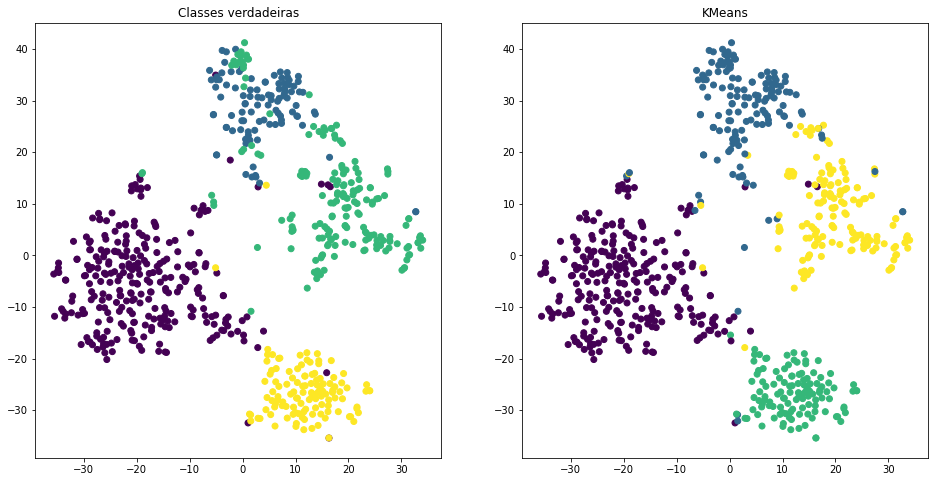

In [7]:
data_clusters_fig, data_clusters_axs = plt.subplots(1, 2)
data_clusters_fig.set_figwidth(16)
data_clusters_fig.set_figheight(8)

data_clusters_axs[0].scatter(
    x=data_tsne_norm[:,0], y=data_tsne_norm[:,1],
    c=data_Y)
data_clusters_axs[0].set_title("Classes verdadeiras")

data_clusters_axs[1].scatter(
    x=data_tsne_norm[:,0], y=data_tsne_norm[:,1],
    c=data_clusters)
data_clusters_axs[1].set_title("KMeans")
plt.show()